# Import and Check Data

In [28]:
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import csv
import math
import random
import numpy as np
import pandas as pd
import re
import cv2
from collections import defaultdict

from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import classification_report

from PIL import Image
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from skimage.feature import hog

df_train = pd.read_csv("fashion-mnist_train.csv\\fashion-mnist_train.csv")
df_test = pd.read_csv("fashion-mnist_test.csv\\fashion-mnist_test.csv")
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values


In [29]:
print(df_train.shape)
print(df_test.shape)
df_train.head()

(60000, 785)
(10000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Train: 60000 rows of 1 label + 784 pixels to be converted into a 28x28 image
Test: 10000 rows of 1 label + 784 pixels to be converted into a 28x28 image

In [30]:
fashion_mnist_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

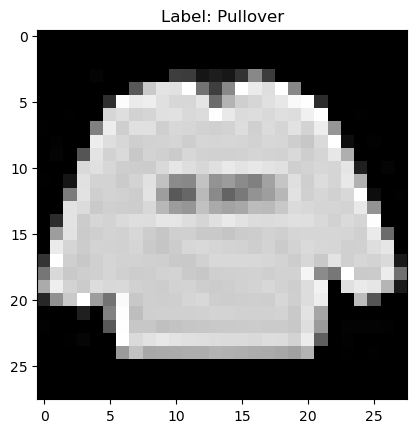

In [31]:
image = df_train.iloc[0, 1:].to_numpy().reshape(28, 28) # Reshape only 1 image into 28x28 pixels
image_label = fashion_mnist_labels[df_train.iloc[0, 0]]

plt.imshow(image, cmap='gray')
plt.title(f"Label: {image_label}")
plt.show()

# HOG Training

In [32]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        fd = hog(img, pixels_per_cell=(4, 4), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys')
        hog_features.append(fd)
    return np.array(hog_features)

In [36]:
# Extract all pixel values (drop label column)
X_train_raw = df_train.iloc[:, 1:].values  # feature shape (60000rows, 784 col)
y_train = df_train.iloc[:, 0].values       # label shape (60000rows,1 col)


X_train_images = X_train_raw.reshape(-1, 28, 28) # Reshape all rows to (28, 28)


X_train_images = X_train_images / 255.0 # Normalize

# Extract HOG features from first 1000 images (for speed)
#X_hog = extract_hog_features(X_train_images[:1000])
X_hog = extract_hog_features(X_train_images)  # for full dataset
y_hog = y_train[:]

print("Shape of HOG feature matrix:", X_hog.shape, y_hog.shape)


Shape of HOG feature matrix: (60000, 1296) (60000,)


In [39]:
X_test_images = X_test.reshape(-1, 28, 28) / 255.0
X_test_hog = extract_hog_features(X_test_images)

In [ ]:
metrics = ['manhattan']
output_file = "knn_results_HOG_manhattan.txt"
with open(output_file, "w") as f:
    f.write("k\tTrain_Acc\tTest_Acc\n")
    f.write("-" * 50 + "\n")
    f.flush()
    for metric in metrics:
        f.write(f"\nTesting distance metric: {metric}\n")      
        print(metric)
        for k in range(1, 16):
            print("KNN: ", k)
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
            knn.fit(X_hog, y_train)
            y_train_pred = knn.predict(X_hog)
            y_test_pred = knn.predict(X_test_hog)

            # Accuracy
            train_acc = accuracy_score(y_train, y_train_pred)
            test_acc = accuracy_score(y_test, y_test_pred)

            report = classification_report(y_test, y_test_pred, target_names=class_names)
            print(train_acc, test_acc)
            print(report)
            f.write(f"k = {k:2d} | Train Acc = {train_acc:.4f} | Test Acc = {test_acc:.4f}\n")
            f.write(report + "\n")
            f.write("=" * 60 + "\n")
            f.flush()
        print(f"[✓] Completed metric: {metric}")

manhattan
KNN:  1
1.0 0.87
              precision    recall  f1-score   support

 T-shirt/top       0.81      0.84      0.83      1000
     Trouser       0.96      0.99      0.97      1000
    Pullover       0.78      0.80      0.79      1000
       Dress       0.88      0.87      0.88      1000
        Coat       0.78      0.79      0.78      1000
      Sandal       0.99      0.93      0.96      1000
       Shirt       0.66      0.61      0.64      1000
     Sneaker       0.91      0.94      0.93      1000
         Bag       0.99      0.97      0.98      1000
  Ankle boot       0.93      0.96      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

KNN:  2
0.9317666666666666 0.8674
              precision    recall  f1-score   support

 T-shirt/top       0.75      0.92      0.83      1000
     Trouser       0.94      0.99      0.96      1000
    Pullover     

We used the first 1000 images of the dataset to train our HOG to extract important features, hence the 1000 rows of 1296 columns (flat vector). The features in X_hog are not images anymore, but some abstract numerical representation of gradient directions and edge strengths. We can try visualising it using:

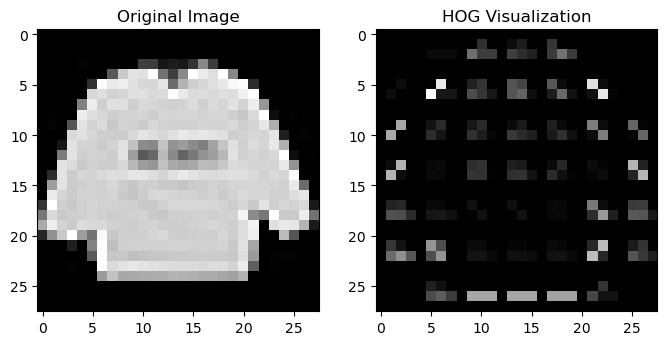

In [8]:
from skimage import exposure


image = df_train.iloc[0, 1:].values.reshape(28, 28) / 255.0 # Recreate the first image from training data and normalise (optional)

# Get both the HOG features and visualization
fd, hog_image = hog(image,
                    orientations=9,
                    pixels_per_cell=(4, 4),
                    cells_per_block=(2, 2),
                    block_norm='L2-Hys',
                    visualize=True)


hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10)) # Rescale image

# Plot
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(hog_image_rescaled, cmap='gray')
plt.title("HOG Visualization")

plt.show()

On the right image:
Bright spots represent a sharp gradient/edge in the original image (strong edge directions)
Dark spots mean there isn't really a change in gradient/flat.

BUT textures are not captured, smaller features like buttons or zippers are also not captured for the middle layer.

###########################################################################

# SIFT Training

Next, I will use SIFT to extract key structures like corners and blobs, focusing on small patterns/details as keypoints. SIFT is also very robust to noise, rotation and zoom. Very good for analysing local parts.

I will
1. Use inbuilt SIFT functions to detect key points and descriptors within the SIFT function
2. Visualise SIFT by comparing to the original 28x28 greyscale image again

In [9]:
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    all_features = []

    for img in images:
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            # Take mean of all descriptors in this image
            feature = np.mean(des, axis=0)
        else:
            # No keypoints found; use zeros
            feature = np.zeros(128)
        all_features.append(feature)

    return np.array(all_features)

In [13]:
# Implement SIFT extraction on first 1000 images
#X_raw = df_train.iloc[:1000, 1:].values.reshape(-1, 28, 28).astype(np.uint8)
#y = df_train.iloc[:1000, 0].values

#X_sift = extract_sift_features(X_raw)

X_raw_full = df_train.iloc[:, 1:].values.reshape(-1, 28, 28).astype(np.uint8)
y_full = df_train.iloc[:, 0].values
X_sift_full = extract_sift_features(X_raw_full)

print("Shape of SIFT feature matrix:", X_sift_full.shape) 

Shape of SIFT feature matrix: (60000, 128)


In [23]:
X_test = X_test.reshape(-1, 28, 28).astype(np.uint8)
X_sift_full_test = extract_sift_features(X_test)

In [41]:
metrics = ['euclidean']
output_file = "knn_results_SIFT.txt"
with open(output_file, "w") as f:
    f.write("k\tTrain_Acc\tTest_Acc\n")
    f.write("-" * 50 + "\n")
    f.flush()
    for metric in metrics:
        f.write(f"\nTesting distance metric: {metric}\n")      
        print(metric)
        for k in range(16, 21):
            print("KNN: ", k)
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
            knn.fit(X_sift_full, y_train)
            y_train_pred = knn.predict(X_sift_full)
            y_test_pred = knn.predict(X_sift_full_test)

            # Accuracy
            train_acc = accuracy_score(y_train, y_train_pred)
            test_acc = accuracy_score(y_test, y_test_pred)

            report = classification_report(y_test, y_test_pred, target_names=class_names)
            print(train_acc, test_acc)
            print(report)
            f.write(f"k = {k:2d} | Train Acc = {train_acc:.4f} | Test Acc = {test_acc:.4f}\n")
            f.write(report + "\n")
            f.write("=" * 60 + "\n")
            f.flush()
        print(f"[✓] Completed metric: {metric}")

euclidean
KNN:  16
0.6540166666666667 0.6152
              precision    recall  f1-score   support

 T-shirt/top       0.58      0.59      0.59      1000
     Trouser       0.62      0.91      0.73      1000
    Pullover       0.52      0.43      0.47      1000
       Dress       0.56      0.51      0.53      1000
        Coat       0.49      0.54      0.51      1000
      Sandal       0.71      0.76      0.74      1000
       Shirt       0.40      0.26      0.32      1000
     Sneaker       0.70      0.70      0.70      1000
         Bag       0.72      0.61      0.66      1000
  Ankle boot       0.77      0.84      0.80      1000

    accuracy                           0.62     10000
   macro avg       0.61      0.62      0.61     10000
weighted avg       0.61      0.62      0.61     10000

KNN:  17
0.6509333333333334 0.6142
              precision    recall  f1-score   support

 T-shirt/top       0.59      0.59      0.59      1000
     Trouser       0.62      0.91      0.74      100

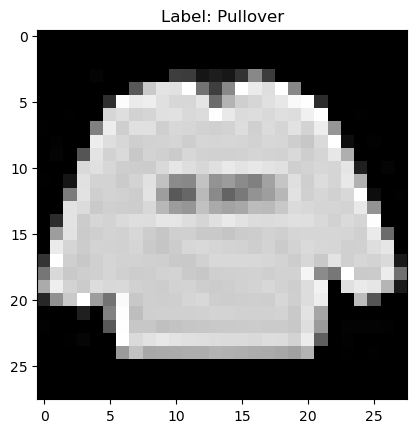

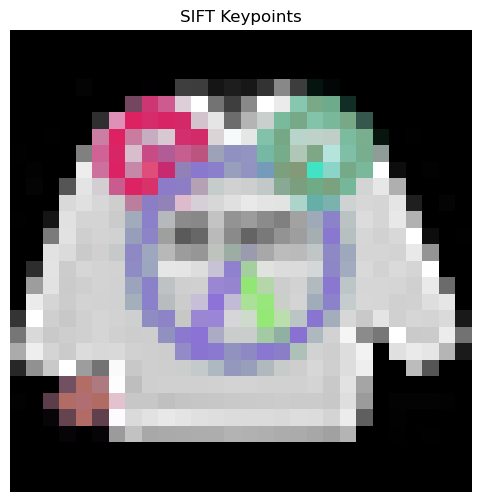

In [11]:
# Show first image and label
image = df_train.iloc[0, 1:].values.reshape(28, 28).astype(np.uint8)
label = df_train.iloc[0, 0]

image = X_raw[0] # Select the first image as an example
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(image, None) # Detect keypoints and descriptors

# Draw keypoints on the image
image_with_kp = cv2.drawKeypoints(
    image, 
    keypoints, 
    None, 
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.imshow(image, cmap='gray')
plt.title(f"Label: {image_label}")
plt.show()

# Show the result of SIFT
plt.figure(figsize=(6, 6))
plt.imshow(image_with_kp, cmap='gray')
plt.title("SIFT Keypoints")
plt.axis('off')
plt.show()